
<img src="HIF-LOGO-UNTERZEILE-HOCH-POS-RGB.png" width="400"  style="float:right;margin:0 1px 1px 0" >

<p style="color:#006400; font-family:Computer Modern; font-size:35px; text-align:center; font-weight:bold">Synthetic multi-scale multivariate borehole segmentation </p>
<p style="color:#006400; font-family:Computer Modern; font-size:15px; text-align:left; font-weight:bold">Created by: Roberto De La Rosa 2021 </p>
<p style="color:#006400; font-family:Computer Modern; font-size:15px; text-align:left; font-weight:bold">Import libraries </p>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import plot, show, axis, subplot, xlabel, ylabel, grid
from skimage.restoration import denoise_tv_chambolle as TV
import pywt
from statsmodels.multivariate.pca import PCA
from statsmodels.multivariate.pca import pca
import pylab
from pylab import *
from scipy.linalg import cholesky
from math import *
import random
import copy
import warnings
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
import seaborn as sns
warnings.filterwarnings('ignore')


<p style="color:#006400; font-family:Computer Modern; font-size:15px; text-align:left; font-weight:bold">Definitions </p>

In [2]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y) 
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return [array[idx],idx]

<p style="color:#006400; font-family:Computer Modern; font-size:15px; text-align:left; font-weight:bold">Synthetic data set creation </p>

In [3]:
# A synthetic multivariate dataset (2 variables in this example) 
# based on the concatenation of 4 pairs of correlated random distributions
#each pair with a different length

#Length of the 4 distributions
n_samp=110
n_samp1=200
n_samp2=400
n_samp3=250

#random variables
ran = random.random()
ran1 = random.random()
ran2 = random.random()
ran3 = random.random()
ran4 = random.random()

#Creation of 4 pairs of random variables
#loc =5 is the mean (center of the distribution) and
# sacle=1 is standard deviation
x1 = np.random.normal(loc=5, scale=1, size=(n_samp))
x2 = np.random.normal(loc=5, scale=1, size=(n_samp))
x3 = np.random.normal(loc=5, scale=1, size=(n_samp1))
x4 = np.random.normal(loc=5, scale=1, size=(n_samp1))
x5 = np.random.normal(loc=5, scale=1, size=(n_samp2))
x6 = np.random.normal(loc=5, scale=1, size=(n_samp2))
x7 = np.random.normal(loc=5, scale=1, size=(n_samp3))
x8 = np.random.normal(loc=5, scale=1, size=(n_samp3))

# 4 pairs
k=[x1,x2]
k1=[x3,x4]
k2=[x5,x6]
k3=[x7,x8]

#Square matrix
r = np.array([[ 3.2+(ran), 1.1+(ran)],[ 1,  3.11+(ran)]])
r1 = np.array([[ 1.06+(ran1), 1+(ran1)],[ 1,  1.005+(ran1)]])
r2 = np.array([[ 3.4+(ran2), 1.2+(ran2)],[ 1,  2.001+(ran2)]])
r3 = np.array([[ 4.01+(ran3), 1.4+(ran3)],[ 1, 4.505+(ran3)]])

# c_i is the Cholesky decomposition, L * L.H, of the square matrix r_i, 
#where L is lower-triangular and .H is the conjugate transpose operator. 
c = cholesky(r, lower=True)
c1 = cholesky(r1, lower=True)
c2= cholesky(r2, lower=True)
c3 = cholesky(r3, lower=True)

#Dot product of Cholesky decomposition and each pair
T = np.dot(c, k)
T1 = np.dot(c1, k1)
T2 = np.dot(c2, k2)
T3 = np.dot(c3, k3)

#Depth calculation for the synthetic borehole assuming sample frequency of 10 Hz 
# 10 samples per meter
depth = (np.arange(0,n_samp,1))/10
depth1 = (np.arange(0,n_samp1,1))/10
depth2= (np.arange(0,n_samp2,1))/10
depth3 = (np.arange(0,n_samp3,1))/10



<p style="color:#006400; font-family:Computer Modern; font-size:15px; text-align:left; font-weight:bold">Visualization of correlated random distributions along depth </p> 

Text(0.5, 1.0, 'Rand. pair 4')

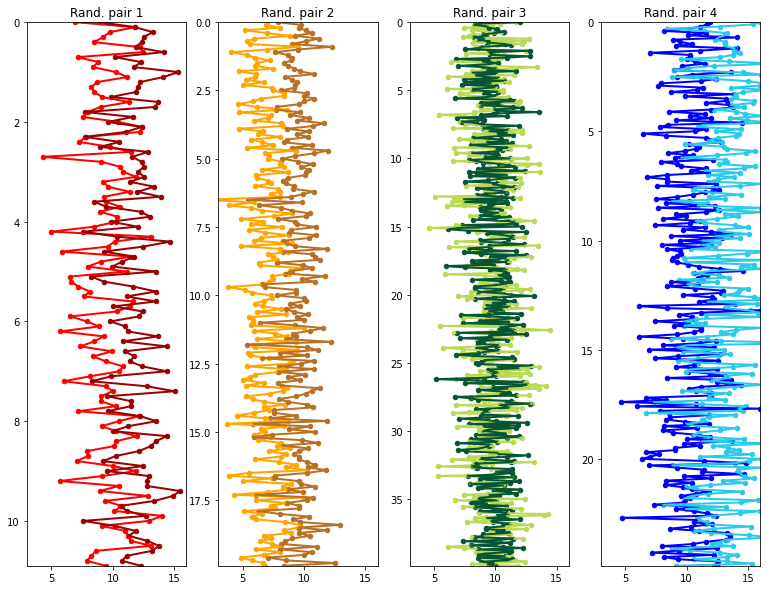

In [4]:
%matplotlib inline
fig= plt.figure(figsize=(20, 10), facecolor='w')
ax = plt.subplot(1,6,1)
plt.scatter (T[0],depth,s=20 ,color= 'red')
plt.plot (T[0],depth, linewidth= 2,color= 'red')
plt.scatter (T[1],depth,s=20 ,color= '#990000')
plt.plot (T[1],depth, linewidth= 2,color= '#990000')
ax.axis([3, 16, min(depth) ,max(depth)] )
plt.gca().invert_yaxis()
plt.title('Rand. pair 1')

ax = plt.subplot(1,6,2)
plt.scatter (T1[0],depth1,s=20 ,color= 'orange')
plt.plot (T1[0],depth1, linewidth= 2,color= 'orange' )
plt.scatter (T1[1],depth1,s=20 ,color= '#b87025')
plt.plot(T1[1],depth1,linewidth= 2 ,color= '#b87025')
ax.axis([3, 16, min(depth1) ,max(depth1)] )
plt.gca().invert_yaxis()
plt.title('Rand. pair 2')

ax = plt.subplot(1,6,3)
plt.scatter (T2[0],depth2,s=20 ,color= '#bada55')
plt.plot (T2[0],depth2, linewidth= 2,color= '#bada55' )
plt.scatter (T2[1],depth2,s=20 ,color= '#065535')
plt.plot (T2[1],depth2, linewidth= 2,color= '#065535' )
ax.axis([3, 16, min(depth2) ,max(depth2)] )
plt.gca().invert_yaxis()
plt.title('Rand. pair 3')

ax = plt.subplot(1,6,4)
plt.scatter (T3[0],depth3,s=20 ,color= 'blue')
plt.plot (T3[0],depth3, linewidth= 2,color= 'blue' )
plt.scatter (T3[1],depth3,s=20 ,color= '#2acaea')
plt.plot (T3[1],depth3, linewidth= 2,color= '#2acaea' )

ax.axis([3, 16, min(depth3) ,max(depth3)] )
plt.gca().invert_yaxis()
plt.title('Rand. pair 4')

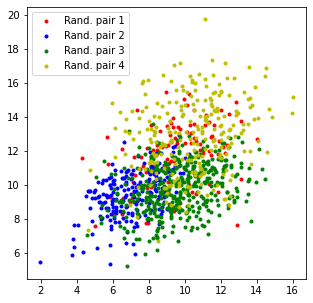

In [5]:
#Scaterplot of variable 2 against variable 1
%matplotlib inline
fig= plt.figure(figsize=(5, 5), facecolor='w')
plot(T[0], T[1], 'r.', label='Rand. pair 1')
plot(T1[0], T1[1], 'b.',label='Rand. pair 2')
plot(T2[0], T2[1], 'g.', label='Rand. pair 3')
plot(T3[0], T3[1], 'y.',label='Rand. pair 4')
plt.legend()

<Figure size 216x216 with 0 Axes>

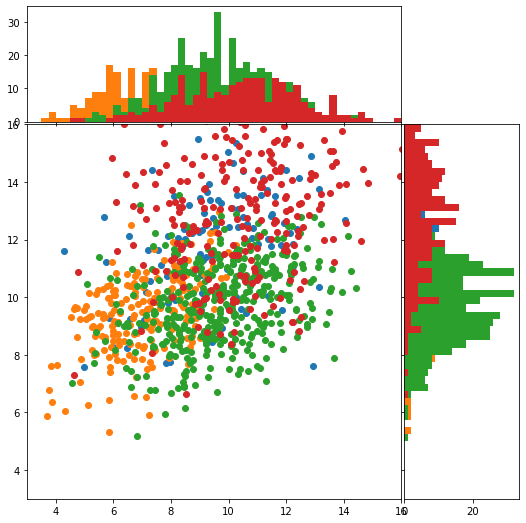

In [6]:
#Scaterplot of variable 2 against variable 1
fig= plt.figure(figsize=(3, 3), facecolor='w')

#definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

#use the previously defined function
scatter_hist(T[0], T[1], ax, ax_histx, ax_histy)
ax.axis([3, 16, 3,16] )
scatter_hist(T1[0], T1[1], ax, ax_histx, ax_histy)
ax.axis([3, 16, 3,16] )
scatter_hist(T2[0], T2[1], ax, ax_histx, ax_histy)
ax.axis([3, 16, 3,16] )
scatter_hist(T3[0], T3[1], ax, ax_histx, ax_histy)
ax.axis([3, 16, 3,16] )
plt.show()

<p style="color:#006400; font-family:Computer Modern; font-size:15px; text-align:left; font-weight:bold">Concatenation of correlated variables to create synthetic variables</p> 

In [7]:
#Variables 1 and 2 concatenation
data1 = np.concatenate((T[0],T1[0],T2[0],T3[0]), axis=0)
data2 = np.concatenate((T[1],T1[1],T2[1],T3[1]), axis=0)
data_raw = [data1,data2]
data_raw = np.transpose(data_raw)

#Total borehole depth calculation
Depth = (np.arange(0,len(data1),1))/10
int_depth= [n_samp,n_samp1,n_samp2,n_samp3]
in_depth = (np.cumsum(int_depth))/10

#Calculate difference between variable 1 and variable 2
data3 = data1-data2

# Variables info
Headers = ['Variable 1', 'Variable 2']
column=[0,1]

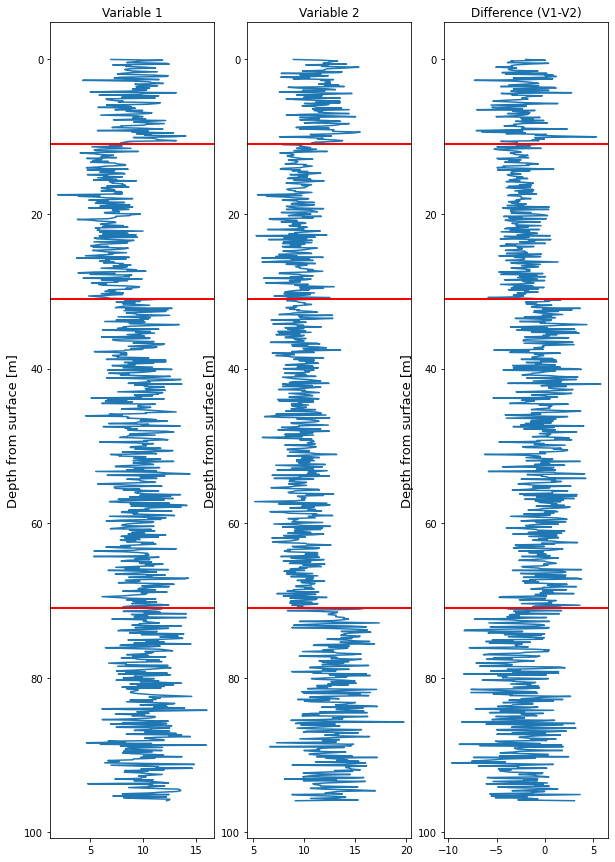

In [8]:
#Synthetic variables vizualization along borehole 
# synthetic contact marked in red
fig= plt.figure(figsize=(10, 15), facecolor='w')
ax = plt.subplot(1,3,1)
plt.plot (data1,Depth)
plt.gca().invert_yaxis()
plt.title('Variable 1')
ax.set_ylabel('Depth from surface [m]', fontsize=13)
for x in range (0,len(in_depth)-1):   
    ax.axhline(y=in_depth[x],linestyle='-',linewidth= 2 ,color='red')

ax = plt.subplot(1,3,2)
plt.plot (data2,Depth)
plt.gca().invert_yaxis()
plt.title('Variable 2')
ax.set_ylabel('Depth from surface [m]', fontsize=13)
for x in range (0,len(in_depth)-1):   
    ax.axhline(y=in_depth[x],linestyle='-',linewidth= 2 ,color='red')
    
ax = plt.subplot(1,3,3)
plt.plot (data3,Depth)
plt.gca().invert_yaxis()
plt.title('Difference (V1-V2)')
ax.set_ylabel('Depth from surface [m]', fontsize=13)
for x in range (0,len(in_depth)-1):   
    ax.axhline(y=in_depth[x],linestyle='-',linewidth= 2 ,color='red')


<p style="color:#006400; font-family:Computer Modern; font-size:15px; text-align:left; font-weight:bold">Uncomment the next two cells if you want to apply extra smoothing to the input data.</p> 

In [9]:
# #Data smoothed
# data_tv= np.empty([len(data_raw), len(column)])
# for x in range(0,len(column)):    
#     data_tv[:,x] = TV(data_raw[:,x], weight=4, eps=0.0002, n_iter_max=20000, multichannel=False)

In [10]:
# #Smoothed data Visualization
# fig= plt.figure(figsize=(25, 10), facecolor='w')
# for x in range(0,len(column)):  
#     ax = plt.subplot(1,10,x+1)
#     plt.plot(data_tv[:,x], Depth,linewidth= 1)
#     ax.axes.get_yaxis().set_visible(True)
#     ax.set_title(Headers[x],fontsize=15)    
#     ax.yaxis.set_label_position('right')
#     plt.gca().invert_yaxis()

<p style="color:#006400; font-family:Computer Modern; font-size:15px; text-align:left; font-weight:bold">Run the next cell if the previous two cells were not used. Otherwise comment out.</p> 

In [11]:
data_tv = data_raw

<p style="color:#006400; font-family:Computer Modern; font-size:15px; text-align:left; font-weight:bold">Scales calculations for CWT</p> 

In [12]:
#Variable Redefinition
data = data_raw

#Selection of scales
data_freq =int(len(data)/np.max(Depth))
exponente = np.arange(0,3,1/(data_freq/2))
scales = (data_freq/2)**exponente

<p style="color:#006400; font-family:Computer Modern; font-size:15px; text-align:left; font-weight:bold">Mirror (pad) data</p> 

In [13]:
#mirror data to avoid border effects
pad_data= np.empty([(3*len(data_tv)), len(column)])
for t in range (0,len(column)):
    pad_data[:,t]=np.pad(data_tv[:,t],pad_width=len(data_tv[:,t]), mode='symmetric')    

<p style="color:#006400; font-family:Computer Modern; font-size:15px; text-align:left; font-weight:bold">Mirrowed data Visualization</p> 

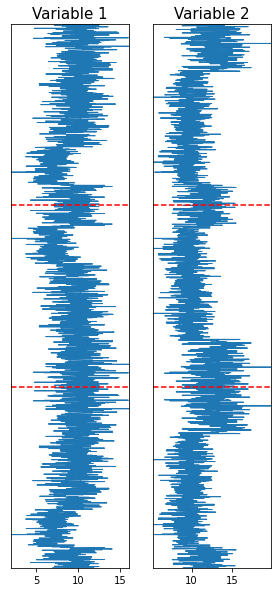

In [14]:
#Mirrowed data Visualization
fig= plt.figure(figsize=(25, 10), facecolor='w')

for x in range(0,len(column)):   
    ax = plt.subplot(1,10,x+1)
    plt.plot(pad_data[:,x], np.arange(0,3*len(Depth),1),linewidth= 1)
    plt.axhline(y=len(Depth),linestyle='--',linewidth= 1.5 ,color='r')
    plt.axhline(y=2*len(Depth),linestyle='--',linewidth= 1.5 ,color='r')
    ax.axis([min(pad_data[:,x]), max(data_tv[:,x]), 3*len(Depth), 0])
    ax.axes.get_yaxis().set_visible(False)
    ax.set_title(Headers[x],fontsize=15)    
    ax.set_ylabel('Depth from surface [m]', fontsize=10)
    ax.yaxis.set_label_position('right')

<p style="color:#006400; font-family:Computer Modern; font-size:15px; text-align:left; font-weight:bold">Apply CWT with Gaus1</p> 

In [15]:
#Selection of gaussian function as wavelet
wavwlet='cgau1'

# cwt calculation
f_cwt =np.empty([len(scales), len(pad_data), len(column)])
for x in range (0,len(column)):    
    f_cwt[:,:,x] = pywt.cwt(pad_data[:,x],scales,wavwlet,method='fft')[0]

#cut the mirrowed borders 
f_cwt =  f_cwt[:,len(data_tv):2*len(data_tv),:]

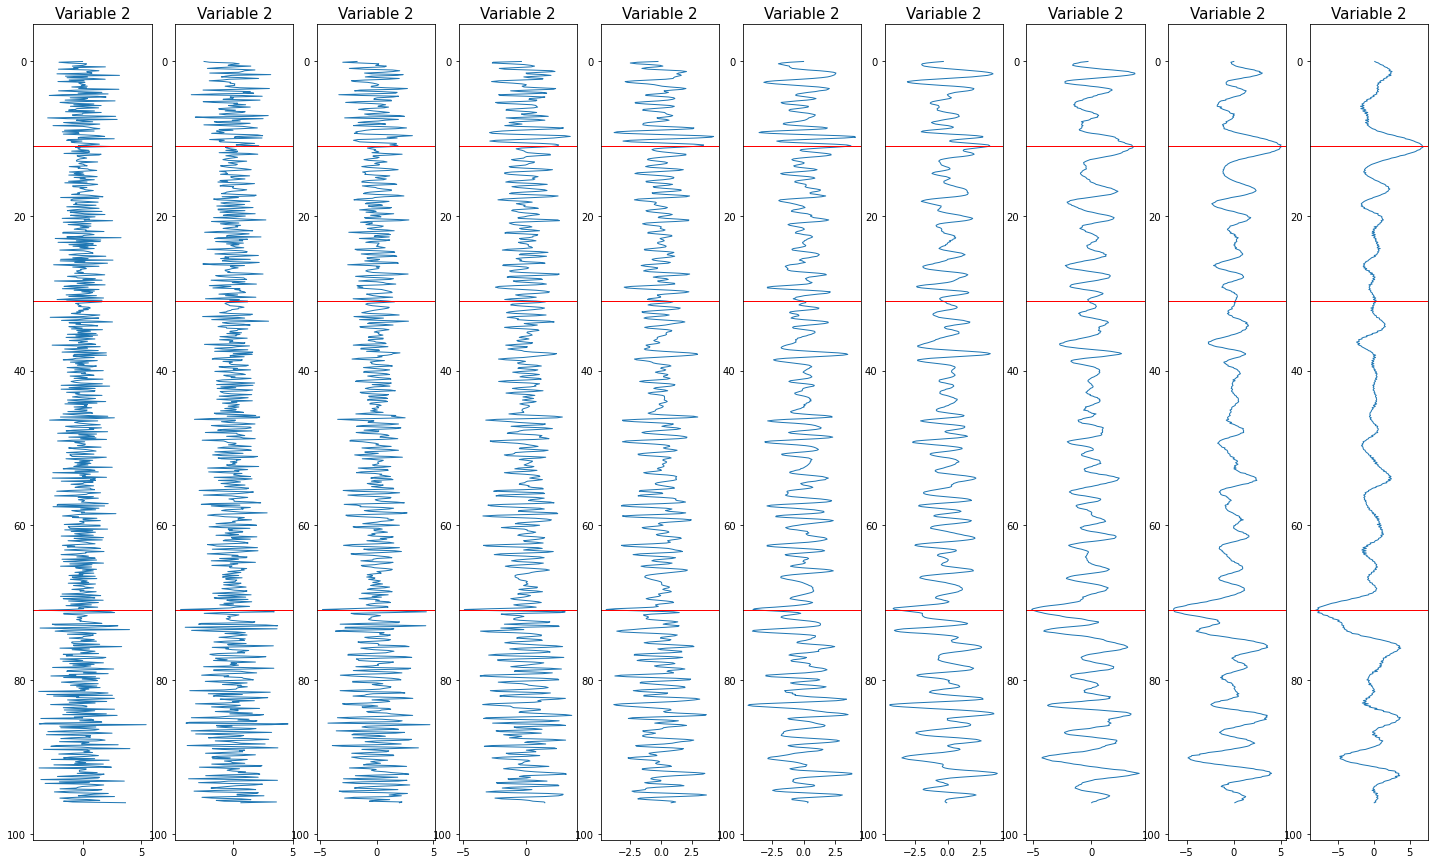

In [16]:
#cwt Data Visualization with Gaus 1
fig= plt.figure(figsize=(25, 15), facecolor='w')

#s = variable selection 0 or 1
s = 1
for x in range(0,10):  
    ax = plt.subplot(1,10,x+1)
    plt.plot(f_cwt[x,:,s], Depth, linewidth= 1)
    ax.axes.get_yaxis().set_visible(True)
    ax.set_title(Headers[s],fontsize=15)    
    ax.yaxis.set_label_position('right')
    plt.gca().invert_yaxis()
 #Plot in red the possition of the synthetic contacts   
    for x in range (0,len(in_depth)-1):   
        ax.axhline(y=in_depth[x],linestyle='-',linewidth= 1 ,color='red')

<p style="color:#006400; font-family:Computer Modern; font-size:15px; text-align:left; font-weight:bold">Moving Window Principal component analysis & Gaussian notch filter parametrization</p> 

In [17]:
#Size of PCA windows is the length of the data divided by the 'interv' variable
interv =48
#step = int(max(np.shape(data))/interv)
step = np.divide (max(np.shape(data)),interv)
step = int (np.round(step,0))
start =0
stop =step

#mirror data to avoid border effects on the gaussian window
data2 = f_cwt
pad_data2= np.empty([len(scales),((np.shape(data2)[1])+2*step), len(column)])
for s in range (0,len(scales)):
    for t in range (0,len(column)):
        pad_data2[s:,:,t]=np.pad(data2[s,:,t],pad_width=int(step), mode='symmetric')

gausiana = np.zeros((step))
#Gaussian shape parameters
a=1
b= step/2 
c= step/4
serie = np.arange(0,step,1)

for s in range (0,step):
    gausiana[s] = a*math.exp((-(serie[s]-b)**2)/(2*c**2))
 

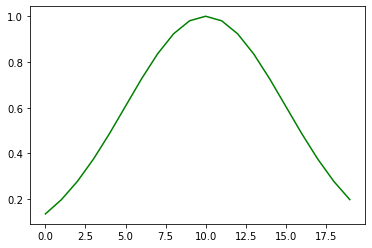

In [18]:
#Viasualization of gaussian notch filter function
plt.plot(gausiana, color='g')

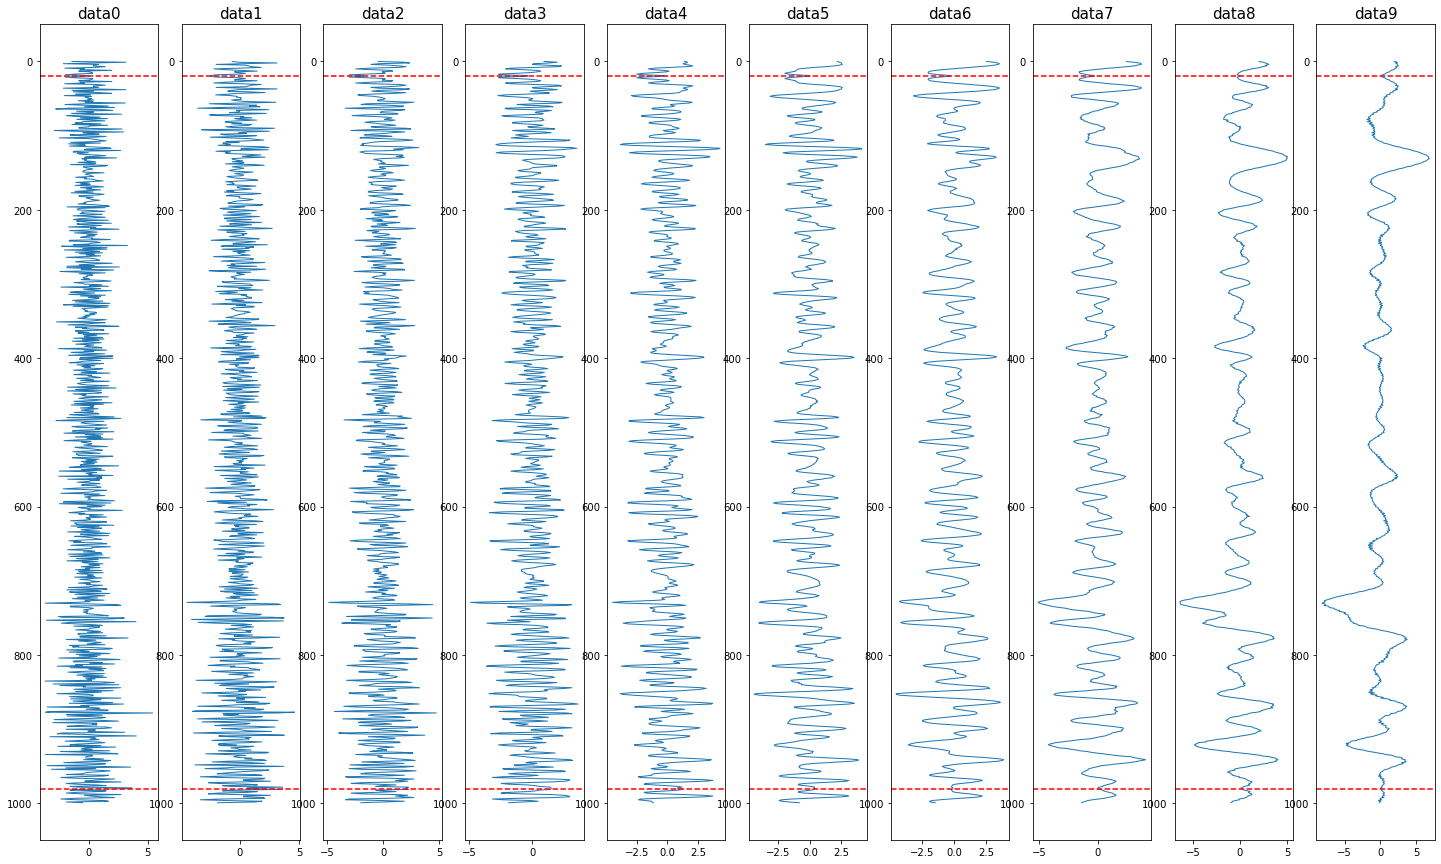

In [19]:
#Visualize paded data (paded with the PCA window size)
fig= plt.figure(figsize=(25, 15), facecolor='w')

for x in range(0,10):  
    ax = plt.subplot(1,10,x+1)
    plt.plot(pad_data2[x,:,1], np.arange(0,np.shape(pad_data2)[1],1),linewidth= 1)
    ax.set_title('data' + str(x) ,fontsize=15)    
    plt.gca().invert_yaxis()
    plt.axhline(y=int(step),linestyle='--',linewidth= 1.5 ,color='r')
    plt.axhline(y=int(step)+np.shape(data2)[1],linestyle='--',linewidth= 1.5 ,color='r')
    

In [20]:
# Step 2 pca over data f_cwt data with gauss 1 in continuos window 

#Variables iniciation
data =  copy.deepcopy(pad_data2)
data_pca = np.zeros(((np.shape(pad_data2)[1])-2*step,len(scales)))
data_pca_gr = np.zeros(((np.shape(pad_data2)[1])-2*step,len(scales)))
Loadings = np.zeros(((np.shape(pad_data2)[1])-2*step,len(column),len(scales)))
Loadings_gr = np.zeros(((np.shape(pad_data2)[1])-2*step,len(column),len(scales)))
data_gauss = np.zeros((len(scales), step,len(column)))
angle =np.zeros(((np.shape(pad_data2)[1])-2*step,len(scales),len(column)))
start = 0
stop = step
start2 = 0
#scale factor that translate in the number of data points
#that will be extrated from the center of the window
f=5
step2 = int(step/f)
stop2 = step2

# i length of data              
for i in range (0, int(((np.shape(pad_data2)[1])-(2*step))/step2)+1):
    
    #d length of scales
    for d in range (0, len(scales)):   
        
        #C number of variables
        for c in range (0,len(column)):
#gaussian filter of the window to reduce border effects
            data_gauss[d,:,c] = data[d,start:stop,c]#*gausiana
            #Calcultae PCA over window and save to temporal variable
            temp = PCA(data_gauss[d,:,:], standardize=False, demean=False, ncomp= 1, method = 'eig')
            if i == 0:
                data_pca[start2:int(stop2/2),d] = temp.factors[int(step/2):int(step/2)+int(step2/2),0]
                data_pca_gr[start2:int(stop2/2),d] = temp.factors[int(step/2):int(step/2)+int(step2/2),0]
                Loadings[start2:int(stop2/2),:,d] = np.reshape(temp.loadings,(len(column)))
                Loadings_gr[start2:int(stop2/2),:,d] = np.reshape(temp.loadings,(len(column)))
           
            if i > 0 and i < int(((np.shape(pad_data2)[1])-(2*step))/step2):         
                data_pca[start2:stop2,d] = temp.factors[int(step/2)-int(step2/2):int(step/2)+int(step2/2),0]
                data_pca_gr[start2:stop2,d] = temp.factors[int(step/2)-int(step2/2):int(step/2)+int(step2/2),0]
                Loadings[start2:stop2,:,d] = np.reshape(temp.loadings,(len(column)))
                Loadings_gr[start2:stop2,:,d] = np.reshape(temp.loadings,(len(column)))
 
                #Angle between vectors of component projection calculation        
                vector_1 = [0,Loadings[i-1,0,d]]
                vector_2 = [0,Loadings[i,0,d]]
                unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
                unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
                dot_product = np.dot(unit_vector_1, unit_vector_2)
               # angle[start2:stop2,d,c] = np.rad2deg(np.arccos(dot_product))        
            
#condition in Angle to reproject the scores and Loadings
                #if abs(angle[1,d,0] - angle[start2,d,0]) >100:
                if abs(dot_product) >0:
                    data_pca[start2:stop2,d] = -temp.factors[int(step/2)-int(step2/2):int(step/2)+int(step2/2),0]
                    Loadings[start2:stop2,:,d] = np.reshape(-temp.loadings,(len(column)))
        
            if i == int(((np.shape(pad_data2)[1])-(2*step))/step2): 
                f_len = len( data_pca[start2:stop2-(int(step2/2)),d])
                data_pca[start2:stop2-(int(step2/2)),d] = temp.factors[int(step/2)-int(step2/2):int(step/2)-int(step2/2)+f_len,0]
                data_pca_gr[start2:stop2-(int(step2/2)),d] = temp.factors[int(step/2)-int(step2/2):int(step/2)-int(step2/2)+f_len,0]
                Loadings[start2:stop2-(int(step2/2)),:,d] = np.reshape(temp.loadings,(len(column)))
                Loadings_gr[start2:stop2-(int(step2/2)),:,d] = np.reshape(temp.loadings,(len(column)))
            
#Angle between vectors of component projection calculation        
                vector_1 = [0,Loadings[i-1,0,d]]
                vector_2 = [0,Loadings[i,0,d]]
                unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
                unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
                dot_product = np.dot(unit_vector_1, unit_vector_2)
                angle[start2:stop2-(int(step2/2)),d,c] = np.rad2deg(np.arccos(dot_product))        
            
#condition in Angle to reproject the scores and Loadings
                if abs(angle[1,d,0] - angle[start2,d,0]) >100:
                    data_pca[start2:stop2-(int(step2/2)),d] = -temp.factors[int(step/2)-int(step2/2):int(step/2)-int(step2/2)+f_len,0]
                    Loadings[start2:stop2-(int(step2/2)),:,d] = np.reshape(-temp.loadings,(len(column)))
                 
    if i == 0:
        start2 = start2 + int(step2/2)
        stop2 = stop2 + int(step2/2)
    if i > 0 and i < (np.shape(pad_data2)[1])-(2*step)-2:  
        start2 = start2 +step2
        stop2 = stop2 + step2
        
    start = start+step2
    stop = stop +step2
    
   
#PCA calculation in unique window
data =  copy.deepcopy(f_cwt)
data_pca = np.zeros((np.shape(data)[1],len(scales)))
for d in range (0, len(scales)):  
    temp = PCA(data[d,:,:], standardize=False, demean=False, ncomp= 1, method = 'eig')
    data_pca[:,d] = temp.factors[:,0]

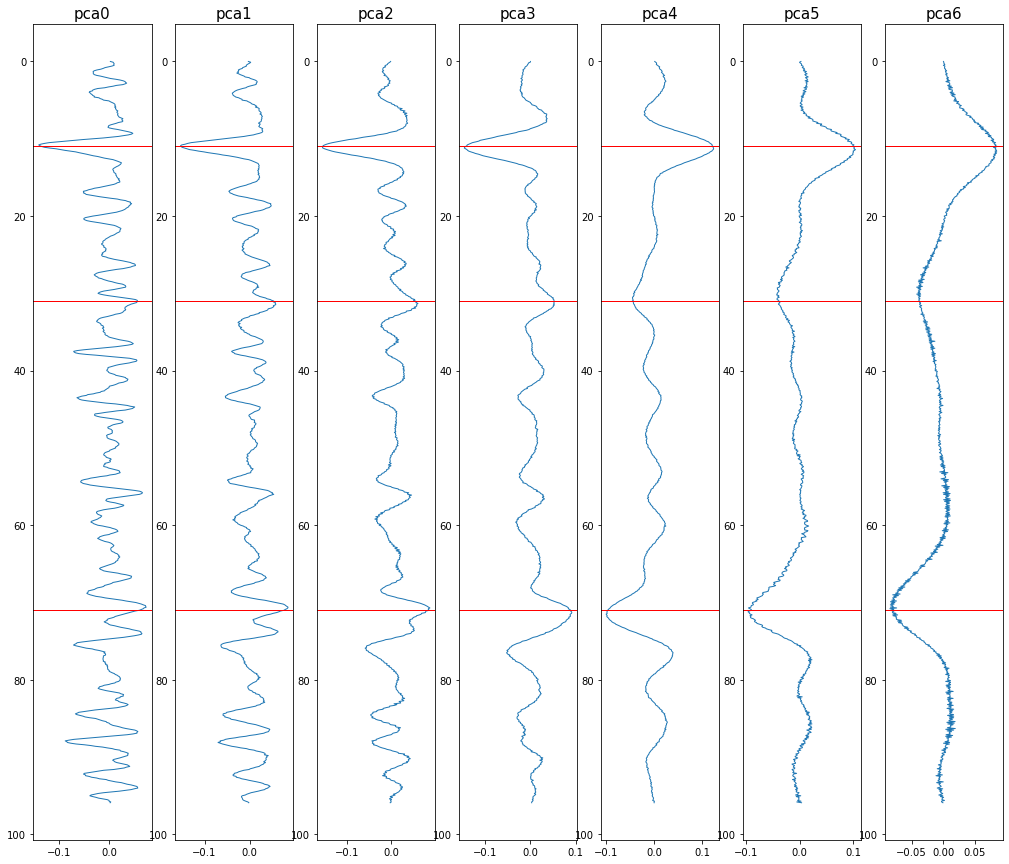

In [21]:
#Compare complete borehole pca at different scales
fig= plt.figure(figsize=(25, 15), facecolor='w')

for x in range(0,7): 
    ax = plt.subplot(1,10,x+1)
    plt.plot(data_pca[:,x+7], Depth,linewidth= 1)
    ax.set_title('pca' + str(x) ,fontsize=15)    
    plt.gca().invert_yaxis()
    for x in range (0,len(in_depth)-1):   
        ax.axhline(y=in_depth[x],linestyle='-',linewidth= 1 ,color='red')

<p style="color:#006400; font-family:Computer Modern; font-size:15px; text-align:left; font-weight:bold">Apply CWT with Gaus2</p> 

In [22]:
data = data_pca
data_tv = data_pca

wavwlet = 'cgau2'
#mirror data to avoid border effects
pad_data= np.empty([(3*len(data_tv)), len(scales)])
for t in range (0,len(scales)):
    pad_data[:,t]=np.pad(data_tv[:,t],pad_width=len(data_tv[:,t]), mode='symmetric')

# cwt calculation
f_cwt =np.empty([len(scales), len(pad_data)])    
for x in range (0,len(scales)):    
    f_cwt[x,:] = pywt.cwt(pad_data[:,x],scales[x],wavwlet,method='fft')[0]
#cut the mirrowed borders 
f_cwt =  f_cwt[:,len(data_tv):2*len(data_tv)]    
    

<p style="color:#006400; font-family:Computer Modern; font-size:15px; text-align:left; font-weight:bold">Mirrowed data Visualization</p> 

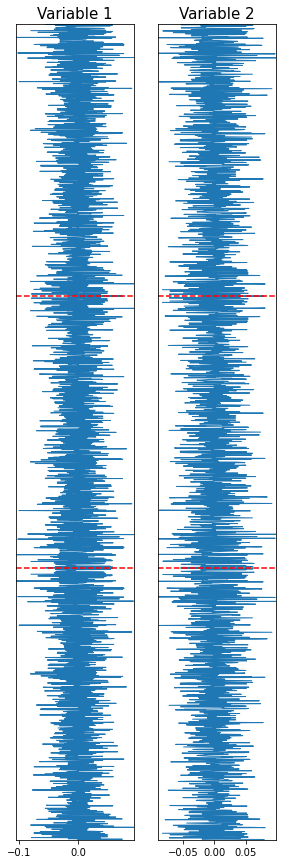

In [23]:
#Mirrowed data Visualization
fig= plt.figure(figsize=(25, 15), facecolor='w')

for x in range(0,2):   
    ax = plt.subplot(1,10,x+1)
    plt.plot(pad_data[:,x], np.arange(0,3*len(Depth),1),linewidth= 1)
    plt.axhline(y=len(Depth),linestyle='--',linewidth= 1.5 ,color='r')
    plt.axhline(y=2*len(Depth),linestyle='--',linewidth= 1.5 ,color='r')
    ax.axis([min(pad_data[:,x]), max(pad_data[:,x]), 3*len(Depth), 0])
    ax.axes.get_yaxis().set_visible(False)
    ax.set_title(Headers[x],fontsize=15)    
    ax.set_ylabel('Depth from surface [m]', fontsize=10)
    ax.yaxis.set_label_position('right')

<p style="color:#006400; font-family:Computer Modern; font-size:15px; text-align:left; font-weight:bold">Visualization of cwt of all variables at specific scale sc</p> 

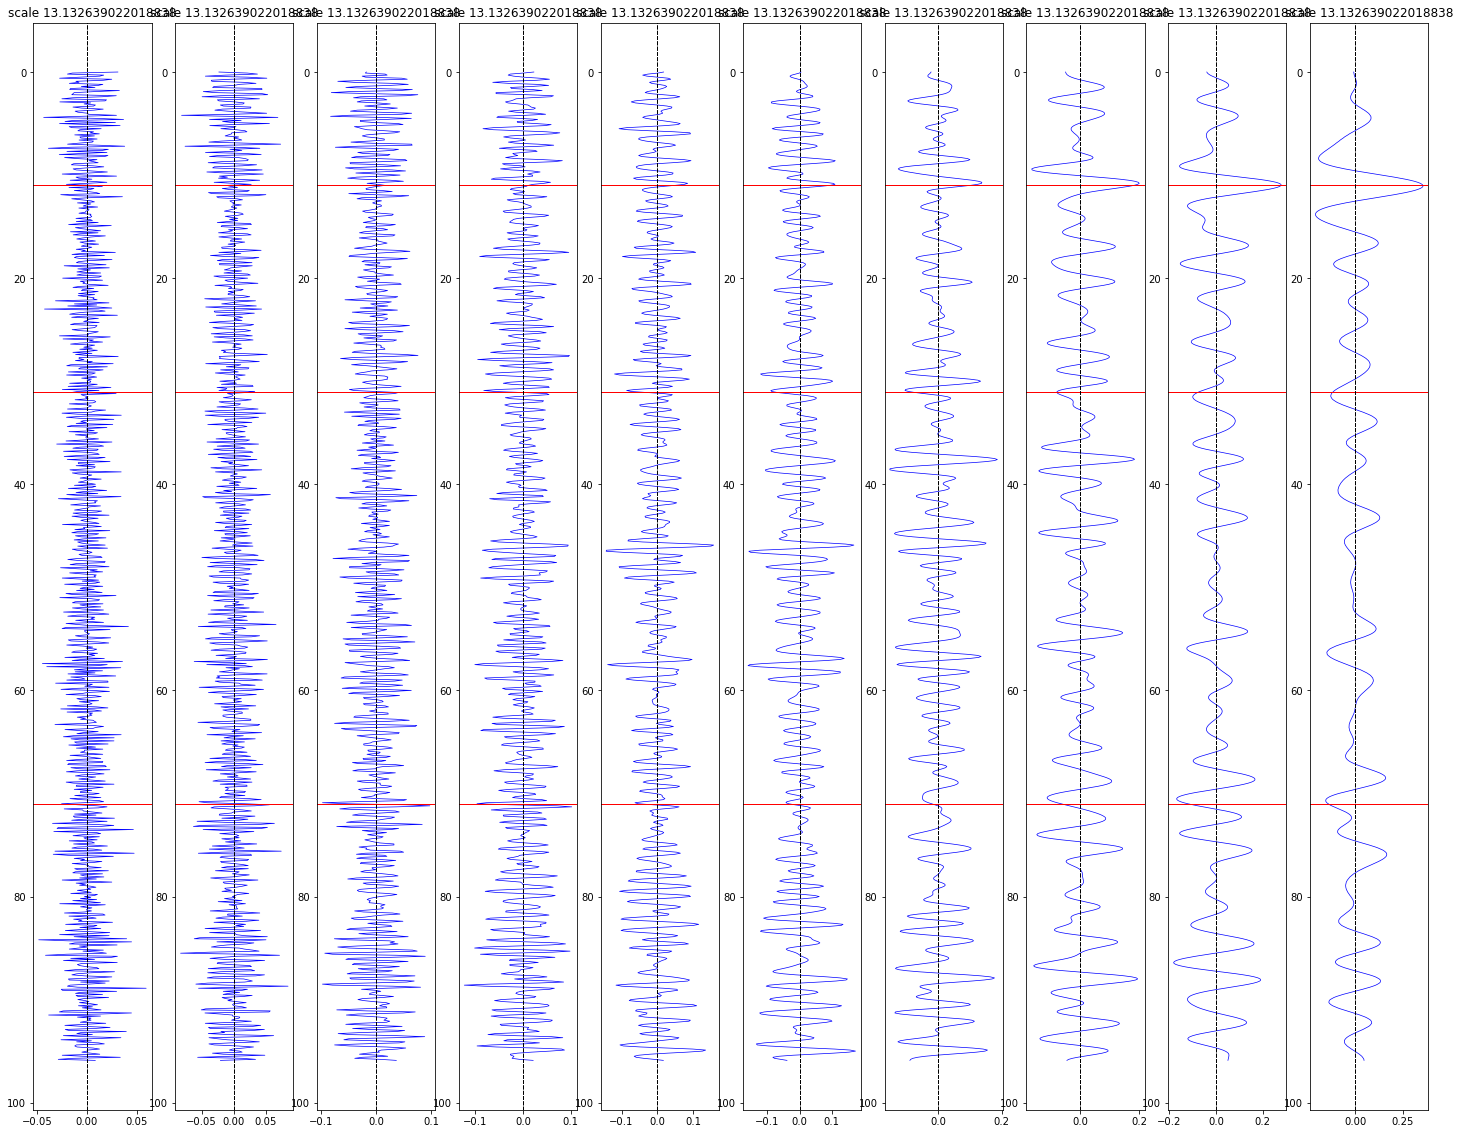

In [24]:
# specific scale sc
sc=8
fig= plt.figure(figsize=(25, 20), facecolor='w')

for x in range(0,10):
    ax = plt.subplot(1,10,x+1)
    plt.plot(f_cwt[x,:], Depth,linewidth= 0.7, color='blue')
    ax.set_title('scale '+ str(scales[sc]))
    #plt.axvline(x=0,linestyle='--',linewidth= 1.5 ,color='black')
    ax.axes.get_yaxis().set_visible(True)
    plt.gca().invert_yaxis()
    for x in range (0,len(in_depth)-1):   
        ax.axhline(y=in_depth[x],linestyle='-',linewidth= 1 ,color='red')
        ax.axvline(x=0,linestyle='--',linewidth= 1 ,color='black')

<p style="color:#006400; font-family:Computer Modern; font-size:15px; text-align:left; font-weight:bold">Contourmap calculation from zero crossing values</p> 

In [26]:
#Variables redefinition
data_pca_tv = f_cwt
y=np.transpose(data_pca_tv[:,:])
#y=data_pca_tv[:,:]
n=range(10*int(round(np.real(np.min(y)))),10*int(round(np.real(np.max(y)))),5)
n=np.divide(n,10)

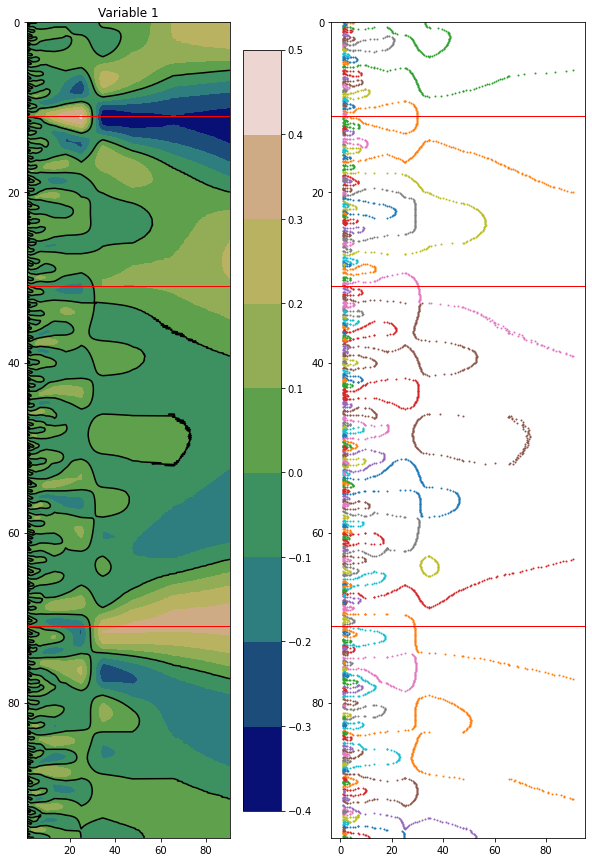

In [27]:
variable =0
cs=plt.contour(scales, Depth, y,[0], colors='black', linestyles='solid')
p=cs.collections[0].get_paths()
plt.close()

fig= plt.figure(figsize=(10, 15), facecolor='w')
ax = plt.subplot(1,2,2)
for x in range (0,len(p)):
    v = p[x].vertices
    xc = v[:,0]
    yc = v[:,1]
    if len(xc)>5:
        plt.scatter(xc,yc, s=1)
    else:
        pass
plt.gca().invert_yaxis()
for x in range (0,len(in_depth)-1):   
    ax.axhline(y=in_depth[x],linestyle='-',linewidth= 1 ,color='red')
ax = plt.subplot(1,2,1, sharey=ax)
plt.contourf(scales, Depth, y,cmap='gist_earth')
plt.title(Headers[variable])
plt.colorbar()
plt.contour(scales, Depth, y,[0], colors='black', linestyles='solid')
for x in range (0,len(in_depth)-1):   
    ax.axhline(y=in_depth[x],linestyle='-',linewidth= 1 ,color='red')


<p style="color:#006400; font-family:Computer Modern; font-size:15px; text-align:left; font-weight:bold">Defining boundary </p>

In [28]:
f_cwt_tv = data_pca_tv
border= np.zeros((1,3))
bd= np.zeros((1,3))
aux= np.zeros((1,3))
i=0
cs=plt.contour(scales, Depth, y,[0], colors='black', linestyles='solid')
p=cs.collections[0].get_paths()
plt.close()

for x in range (0,len(p)):

    v = p[x].vertices
    xc = v[:,0]
    yc = v[:,1]
    #Selection of contourns that reach the edge of the plot at the maximun scale
    a=xc >= scales[-1]  
  #  b=yc > np.max(t_depth/100)-5  
  #  c= yc< np.min(t_depth/100)+5

    if np.any(a) == True and len(xc)>5:
        #try:
        border[i,0]=yc[np.where(xc==np.min(xc))[0][0]]#depth at minimun scale
        border[i,1]=np.max(xc) #Strength coef 
        border[i,2]=np.divide(yc[-1]-yc[0],xc[-1]-xc[0]) #slope
        #except ValueError:  #raised if `y` is empty.
         #   pass
        i=i+1
        border=np.append(border,bd,0)
    else:
        #1 line contourns
        if abs(np.max(xc)-np.min(xc))<2:
            pass
        elif (np.where(xc==np.max(xc))[0][0] < 10 and np.where(xc==np.max(xc))[0][0] >= 0): 
            if len(xc)>10:      
                border[i,0]=yc[np.where(xc==np.min(xc))[0][0]]#depth at minimun scale
                border[i,1]=np.max(xc) #Strength coef 
                border[i,2]=np.divide(yc[-1]-yc[0],xc[-1]-xc[0]) #slope 
                border=np.append(border,bd,0)
            else: 
                pass
        else:
            #divide contourn 
            yc_up=yc[0:np.where(xc==np.max(xc))[0][0]]
            yc_down=yc[(np.where(xc==np.max(xc))[0][0]):]
            xc_up=xc[0:np.where(xc==np.max(xc))[0][0]]
            xc_down=xc[(np.where(xc==np.max(xc))[0][0]):]        

            # fill border database up border
            #try:
            border[i,0]=yc_up[np.where(xc_up==np.min(xc_up))[0][0]]#depth at minimun scale
            border[i,1]=np.max(xc_up) #Strength coef 
            border[i,2]=np.divide(yc_up[-1]-yc_up[0],xc_up[-1]-xc_up[0]) #slope        
            # fill border database down border
            aux[0,0]=yc_down[np.where(xc_down==np.min(xc_down))[0][0]]#depth at minimun scale
            aux[0,1]=np.max(xc_down) #Strength coef 
            aux[0,2]=np.divide(yc_down[-1]-yc_down[0],xc_down[-1]-xc_down[0]) #slope
            border= np.append(border,aux,0)
            i=i+2
            border=np.append(border,bd,0)
            #except ValueError:  #raised if `y` is empty.
;             #   pass
#remove zero from array
border = border[~np.all(border == 0, axis=1)]

#clear nan
idx=np.where(np.isnan(border))[0]
border= np.delete(border, idx,axis=0)

In [29]:
#Merge boundaries at same depth
#Sort borders by depth 
border = border[border[:, 0].argsort()]   

unif_borders = [] 
joint_borders = border
i = 0

x = len(joint_borders)
#for x in range (0,4003):
while x > 0:
    dif_depth =abs(joint_borders[:,0]- joint_borders[i,0]) # Difference in depth from one border to all the rest
    to_joints = np.where((dif_depth <(0.0001*np.mean(diff(Depth))))) #how many borders have a depth diference less than 2 data points length

    #Join the borders that fullfill the last condition 

    sub_set = joint_borders[to_joints] #subset of borders to join 
    max_subset = sub_set[np.where(sub_set[:,1] == max(sub_set[:,1]))[0][0]] #Border with max amplitud
    #step = len(sub_set)
    step = 1
    # Depth
    a =  max_subset[0] # Depth of border with max amplitud

    # Amplitude
    # New amplitude is the square root of the sum of the squared individual amplitudes
    b = sqrt(sum(sub_set[:,1]**2))

    # Slope
    c = max_subset[2]# Slope of border with max amplitud

    new_border =[a,b,c] 
    unif_borders.append(new_border)
    i = i+step
    x = x-step

unif_borders = np.array(unif_borders)

#delete repeated borders
del2 = []
for i in range (0,len(unif_borders)-1):
    dif_depth2 =abs(unif_borders[i,0]- unif_borders[i+1,0]) # Difference in depth from one border to all the rest
    if dif_depth2 <(data_freq/2)/10:
        del2.append([i])

unif_borders= np.delete(unif_borders, del2,axis=0)
border = unif_borders

#re-scale final borders from 0 to 100 
new_rescale = copy.deepcopy(border)
for x in range (0,len(unif_borders)):
     new_rescale[x][1] = 100*(unif_borders[x][1]/max(unif_borders[:,1]))
border = new_rescale

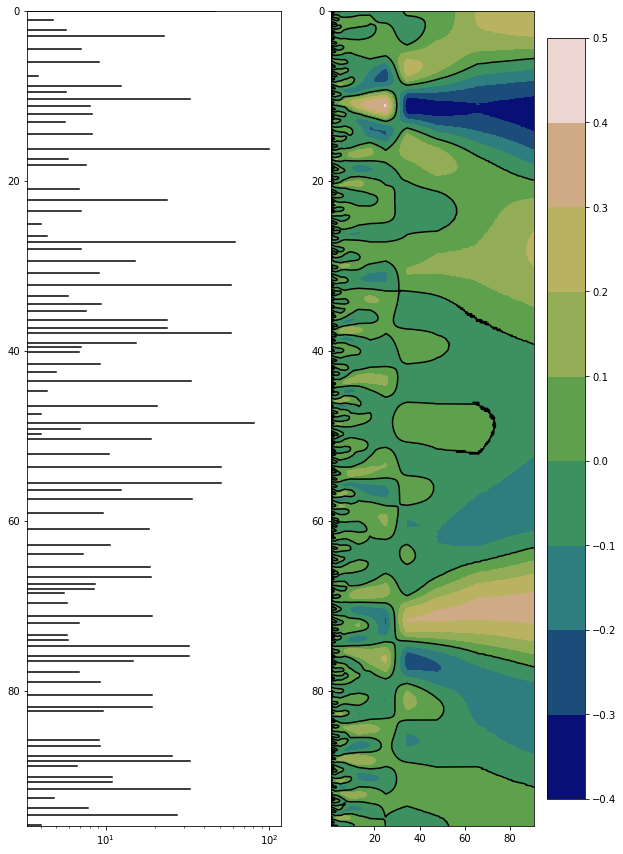

In [30]:
fig= plt.figure(figsize=(10, 15), facecolor='w')

ax = plt.subplot(1,2,1)
for x in range(0,len(border)):   
    plt.plot([0,border[x,1]],[border[x,0],border[x,0]],color='black')
plt.xscale("log")
plt.gca().invert_yaxis()
ax = plt.subplot(1,2,2, sharey=ax)

plt.contourf(scales, Depth, y, cmap='gist_earth')
plt.colorbar()
plt.contour(scales, Depth, y,[0], colors='black', linestyles='solid')
plt.gca().invert_yaxis()
plt.gca().invert_yaxis()
plt.show()


<p style="color:#006400; font-family:Computer Modern; font-size:15px; text-align:left; font-weight:bold">Scalogram Construction </p>

In [31]:
border = border[border[:,0].argsort()]
data2 = np.zeros((border.shape[0],4))
data2[:,0] = np.arange(0,border.shape[0],1) #data2 1st colum is index 
data2[:,1:4] = border #Data2 2dn is depth , data2 3er is Amplitud,  data2 4th is slope

tasks = []
processed = []
split = []
split0 = np.argmax(data2[:,2]) #Split the dataset in two by the max amplitude 


split.append([split0])
tasks.append([0,split0])
tasks.append([split0,border.shape[0]-1])
processed = copy.deepcopy(tasks)

while len(tasks)>0:
    if len(tasks)>0:
        inputs=tasks[0]
        sub_indices = np.argsort(data2[inputs[0]:inputs[1],2]) #index of data2 inside task order from minor to max amplitude
        indices = data2[inputs[0]:inputs[1]][sub_indices][:,0].astype(int)
        
        if len(indices)<2:
            tasks = tasks[1::]
            split.append([np.inf])
            #print(tasks)
        else:
            if indices[-1]==0:
                ind=indices[-2]
                
            elif indices[-1]==inputs[0]:
                ind=indices[-2]
            else:
                ind=indices[-1]

            if ind==0 or ind==inputs[-1]:
                tasks = tasks[1::]
                split.append([np.inf])
                #print(tasks)                

            else:
                split0 = int(data2[ind,0])

                processed.append([inputs[0],split0])
                processed.append([split0,inputs[1]])
                tasks.append([inputs[0],split0])
                tasks.append([split0,inputs[1]])
                split.append([split0])
                tasks = tasks[1::]
                #print(tasks)

In [32]:
inter = [] 
values = []
for i in range(0,len(split)-2):
    prof_from = data2[processed[i][0]][1]
    prof_to = data2[processed[i][1]][1]
    if prof_from - prof_to ==0:
        value = mean(data_raw[:,1])
        values.append([value])
        inter.append([processed[i][0],processed[i][1],split[i+1][0],value])
    else:
        value = np.mean(data_raw[(find_nearest(Depth,prof_from)[1]):(find_nearest(Depth,prof_to)[1])])
        #value = int(value *1000)
        values.append([value])
        inter.append([processed[i][0],processed[i][1],split[i+1][0],value])
 
############### Mean value for each area
prof_from = data2[processed[i][0]][1]
prof_to = data2[processed[i][1]][1]
value = np.mean(data_raw[(find_nearest(Depth,prof_from)[1]):(find_nearest(Depth,prof_to)[1])])

############## Poligons for scalogram map
polygon = []
pl = []

for i in range(0,len(inter)):
    y1=data2[inter[i][0]][1]
    y2=data2[inter[i][1]][1]
    
    if i <2:
        x2= max(data2[inter[i][0]][2],data2[inter[i][1]][2])
        
    elif data2[inter[i][0]][1] == data2[0][1] or data2[inter[i][1]][1] == data2[-1][1]:
        x2= max(data2[inter[i][0]][2],data2[inter[i][1]][2])            
    else:
        x2= min(data2[inter[i][0]][2],data2[inter[i][1]][2])
        if x2 <x1:
            x2= max(data2[inter[i][0]][2],data2[inter[i][1]][2])
        else: 
            x2= min(data2[inter[i][0]][2],data2[inter[i][1]][2])     
    
    if inter[i][2]==np.inf:
        x1=0               
    else:                 
        x1=data2[inter[i][2]][2]
                
    pl =[x1,y1,x1,y2,x2,y2,x2,y1]
    polygon.append(pl)

<p style="color:#006400; font-family:Computer Modern; font-size:15px; text-align:left; font-weight:bold">Multivariate borehole segmentation, Scalogram </p>

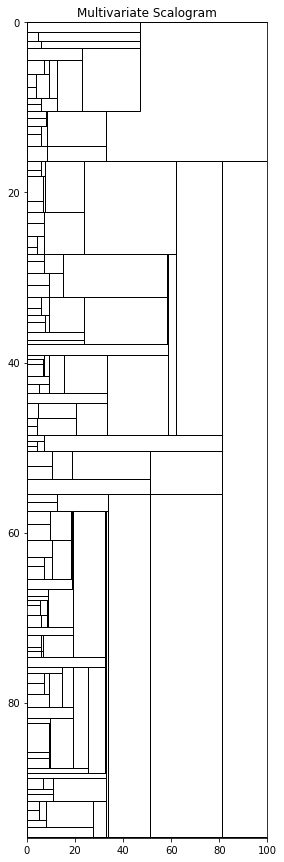

In [33]:
s_scale = 1
variable=0
wav = np.linspace(min(values),max(values),100)
cmap = cm.get_cmap('tab20') 
fig= plt.figure(figsize=(25, 15), facecolor='w')

ax = fig.add_subplot(1,5,1, sharey=ax, xlim=(0, max(border[:,1])), ylim=(0, max(Depth)))
ax.set_title('Multivariate Scalogram')

for i in range (0,np.shape(polygon)[0]):
    contador = find_nearest(wav,values[i][0])[1]
    rgba = cmap(contador)
    
    poly = [[polygon[i][0],polygon[i][1]],[polygon[i][2],polygon[i][3]],[polygon[i][4],polygon[i][5]],[polygon[i][6],polygon[i][7]]]
    ax.add_patch( plt.Polygon(poly, fc='white', ec='black'))
plt.gca().invert_yaxis()    
a = np.array([[min(values)[0],max(values)[0]]])
plt.show() 

<p style="color:#006400; font-family:Computer Modern; font-size:15px; text-align:left; font-weight:bold">Unsupervised domaining </p>

In [34]:
groups = []
for i in range(0,len(split)-2):
    prof_from = data2[processed[i][0]][1]
    prof_from = find_nearest(Depth,prof_from)[1]
    prof_to = data2[processed[i][1]][1]
    prof_to = find_nearest(Depth,prof_to)[1] 
    group = [np.average(data_raw[prof_from:prof_to,0]),np.average(data_raw[prof_from:prof_to,1])]
    groups.append([group])

groups = np.reshape(groups,(np.shape(groups)[0],np.shape(groups)[2]))
X= groups
# build dendrogram
Z = linkage( X, method='average', metric='sqeuclidean', optimal_ordering=False)

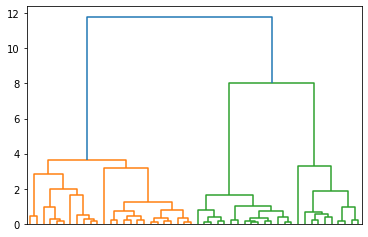

In [35]:
# plot dendrogram
dendrogram(Z, show_leaf_counts=True, no_labels=True, truncate_mode='lastp', p=50)
plt.show()

In [36]:
# cut tree to extract clusters
n=3
C = cut_tree( Z, n )[...,0]

In [37]:
for v,n in np.array(np.unique(C, return_counts=True )).T:
    print("Class %d" % v, "has %d members." % n)

Class 0 has 65 members.
Class 1 has 70 members.
Class 2 has 30 members.


In [38]:
#Manual color definitions
gray = (0.5,0.5,0.5); red = (1,0,0); blue = (0,0,1); green = (0,1,0); yellow = (1,1,0); clearblue = (0,1,1)
purple = (1,0,1); mostaza = (1,0.5,0); pink = (1,0,0.5); cleargreen = (0,1,0.5); clearblue2 = (0,0.5,1)
intensegreen = (0.5,1,0); darkpurple = (0.5,0,1); carne = (1,0.8,0.8); brown = (0.4,0,0); darkblue =(0,0,0.4)
andesite = (0.4, 0.5, 0.2); shale = (0.5, 0.5, 0.5); massive=(1,0.8,1); semi=(0.4, 0.3, 0.6); qz=(0.7, 0.1, 0.0)
tufa=(0.2, 0.6, 0.6); blacks=(0.7, 0.5, 0.3); faultb=(1.0 , 0.8, 0.8)
colors3 = [(andesite),(shale),(tufa)]

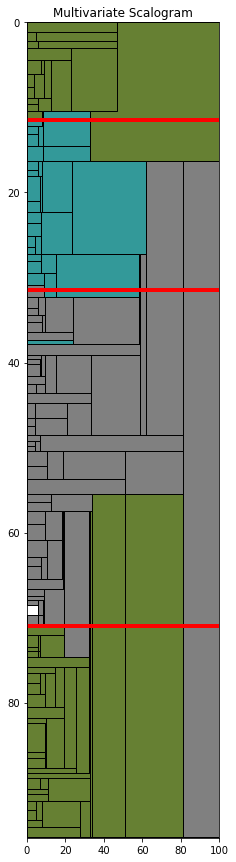

In [39]:
s_scale = 100

wav = C
#wav = np.divide (wav,1000)
cmap = cm.get_cmap('tab20') 
fig= plt.figure(figsize=(20, 15), facecolor='w')

ax = fig.add_subplot(1,5,1, sharey=ax, xlim=(0, s_scale), ylim=(0, max(Depth)))
ax.set_title('Multivariate Scalogram')

for i in range (0,np.shape(polygon)[0]):
#     contador = C[i]
#     rgba = cmap(contador)
    
    poly = [[polygon[i][0],polygon[i][1]],[polygon[i][2],polygon[i][3]],[polygon[i][4],polygon[i][5]],[polygon[i][6],polygon[i][7]]]
    ax.add_patch( plt.Polygon(poly, fc=colors3[C[i]], ec='black'))
plt.gca().invert_yaxis()    
a = np.array([[int(min(C)),int(max(C))]])

for x in range (2,len(in_depth)-1):   
    ax.axhline(y=in_depth[x],linestyle='-',linewidth= 4 ,color='red')    
for x in range (0,len(in_depth)-2):   
    ax.axhline(y=in_depth[x]+0.5,linestyle='-',linewidth= 4 ,color='red')    
plt.show() 

Text(0, 0.5, 'Variable: Data 2')

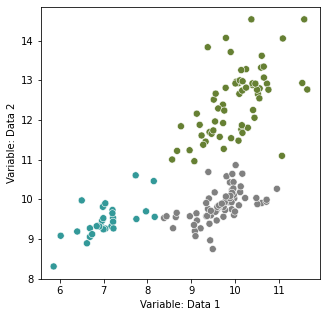

In [40]:
from matplotlib.colors import ListedColormap
fig= plt.figure(figsize=(5, 5), facecolor='w')
cmap = ListedColormap(colors3)
sns.scatterplot(groups[:,0],groups[:,1], s=50, c=C, cmap=cmap)
plt.xlabel('Variable: Data 1')
plt.ylabel('Variable: Data 2')